# Jensen-Shannon-Divergence between Amino Acid Distributions

In [1]:
import re
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df_with_outliers = pd.concat(dfs)

In [3]:
# Filter to sequences that do not have distr
df = df_with_outliers[df_with_outliers['aa_distr_js'].notnull()]

In [4]:
df.describe()

,seq_len,domain_count,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,iupred_plddt_spearman,repeat_6mers_2000,non_repeat_6mers_2000,aa_distr_js,freq_pos_charge,freq_neg_charge,freq_polar,freq_non_polar,IEP,suboptim_compress
count,1.072382e+06,530639.000000,1.072382e+06,1.072382e+06,1.072382e+06,1.072382e+06,1.072379e+06,513491.000000,1.056365e+06,1.056365e+06,1.072382e+06,1.072382e+06,1.072382e+06,1.072382e+06,1.072382e+06,1.072382e+06,207722.000000
mean,3.865054e+02,0.555003,3.921522e+01,8.155128e+01,8.521324e+01,2.432901e-01,6.116737e+01,-0.311983,4.908758e-01,9.778296e-01,1.582429e-01,1.408789e-01,1.159461e-01,5.110148e-01,2.321597e-01,7.157321e+00,0.133778
std,3.106942e+02,1.097002,1.508290e+01,1.428870e+01,1.660780e+01,2.694905e-01,1.202918e+02,0.317159,4.024742e+00,4.935259e+00,6.244004e-02,4.279119e-02,3.881219e-02,7.133074e-02,5.411152e-02,1.922474e+00,0.101513
min,1.600000e+01,0.000000,1.390000e+00,2.307730e+01,2.217000e+01,0.000000e+00,0.000000e+00,-0.987435,0.000000e+00,0.000000e+00,3.044343e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.050000e+00,0.000000
25%,1.790000e+02,0.000000,2.791000e+01,7.325035e+01,8.218000e+01,3.470000e-02,2.268000e-01,-0.564031,0.000000e+00,0.000000e+00,1.139000e-01,1.172000e-01,9.420000e-02,4.683000e-01,1.977000e-01,5.506800e+00,0.054900
50%,3.130000e+02,0.000000,3.527000e+01,8.612400e+01,9.256000e+01,1.343000e-01,5.434000e-01,-0.345583,0.000000e+00,0.000000e+00,1.457000e-01,1.369000e-01,1.173000e-01,5.090000e-01,2.286000e-01,6.547900e+00,0.112800
75%,4.880000e+02,1.000000,4.668000e+01,9.298427e+01,9.642500e+01,3.682000e-01,7.683335e+01,-0.103957,0.000000e+00,1.000000e+00,1.881000e-01,1.584000e-01,1.380000e-01,5.510000e-01,2.615000e-01,8.933500e+00,0.194200
max,2.699000e+03,46.000000,9.738000e+01,9.875400e+01,9.887000e+01,1.000000e+00,2.730700e+03,0.918797,3.860000e+02,6.730000e+02,7.746000e-01,9.524000e-01,8.889000e-01,1.000000e+00,9.875000e-01,1.200000e+01,0.680400


In [5]:
from scipy.stats import spearmanr

rho, p = spearmanr(df['ratio_bad_plddt'], df['aa_distr_js'])
print(f'Spearman rank correlation (Jensen-Shannon): {"{0:.4f}".format(rho)}')

Spearman rank correlation (Jensen-Shannon): 0.1981


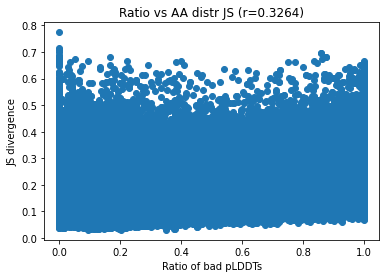

In [6]:
%matplotlib inline
fig, ax = plt.subplots()

ax.scatter(df['ratio_bad_plddt'], df['aa_distr_js'])
ax.set_title('Ratio vs AA distr JS (r=0.3264)')
ax.set_ylabel('JS divergence')
ax.set_xlabel('Ratio of bad pLDDTs')

plt.show()

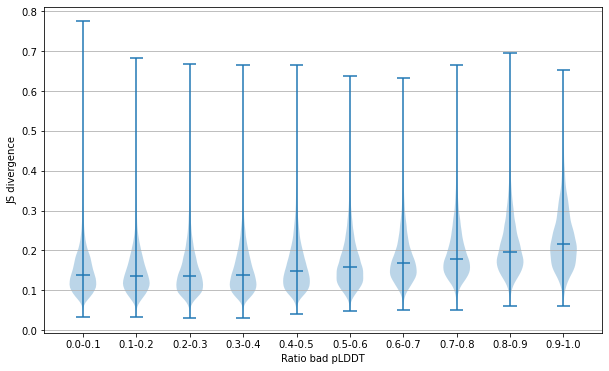

In [7]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, figsize=(10, 6))

def violin_plot(ax, prop, title, bucket_step_size=0.1, decimals=1):
    xprop = 'ratio_bad_plddt'
    df_without_na = df.dropna(subset=[prop])
    buckets_indices = np.arange(np.floor(df_without_na[xprop].min()), df_without_na[xprop].max(), bucket_step_size)
    buckets = [df_without_na[df_without_na[xprop].between(i, i + bucket_step_size, inclusive='left')] for i in buckets_indices]
    labels = [f'{np.round(i, decimals=decimals)}-{np.round(i + bucket_step_size, decimals=decimals)}' for i in buckets_indices]
    ax.violinplot(dataset = [bucket[prop].values for bucket in buckets], showmedians=True)
    ax.yaxis.grid(True)
    ax.set_xlabel('Ratio bad pLDDT')
    ax.set_ylabel(title)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

violin_plot(ax1, 'aa_distr_js', 'JS divergence')